In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import curve_fit


Load data.

In [52]:
file_path = 'C:/Users/rasmu/Desktop/Speciale/LoggedDataByVessel_BathymetryUpdated.xlsx'
df = pd.read_excel(file_path)

Check shape

In [53]:
print(df.shape)

(36891, 107)


Lets look at the missing values

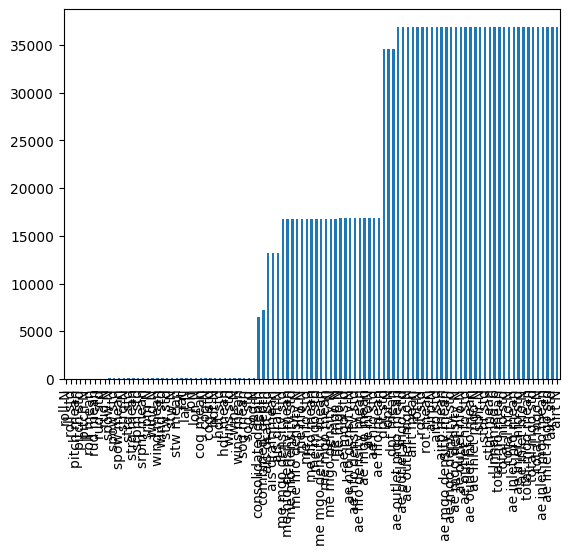

In [54]:
# Display the distribtuion of missing values in a graph
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values.sort_values(inplace=True)
missing_values.plot.bar()
plt.show()


Lets remove the columns that does not have any or enough information to be useful.

In [55]:
# Display column names before removal
print("Columns before removal:", df.columns.tolist())

# Remove columns with more than 20% NaN values
threshold = 0.2
df = df.loc[:, df.isnull().mean() <= threshold]

# Display column names after removal
print("Columns after removal:", df.columns.tolist())
# count the number of columns left
print("Number of columns left:", len(df.columns))

# print shape to insure that I did not remove any rows
print(df.shape)


Columns before removal: ['start', 'end', 'lat', 'lat N', 'lon', 'lon N', 'Unnamed: 6', 'sog mean', 'sog std', 'sog N', 'cog mean', 'cog std', 'cog N', 'stw mean', 'stw std', 'stw N', 'hdt mean', 'hdt std', 'hdt N', 'wins mean', 'wins std', 'wins N', 'wind mean', 'wind std', 'wind N', 'airt mean', 'airt std', 'airt N', 'airp mean', 'airp std', 'airp N', 'rot mean', 'rot std', 'rot N', 'rud mean', 'rud std', 'rud N', 'pitch mean', 'pitch std', 'pitch N', 'roll mean', 'roll std', 'roll N', 'dpt mean', 'dpt std', 'dpt N', 'ais draft N', 'ais draft mean', 'ais draft std', 'spow mean', 'spow std', 'spow N', 'srpm mean', 'srpm std', 'srpm N', 'strq mean', 'strq std', 'strq N', 'sthr mean', 'sthr std', 'sthr N', 'me hfo mean', 'me hfo std', 'me hfo N', 'ae hfo mean', 'ae hfo std', 'ae hfo N', 'me mgo mean', 'me mgo std', 'me mgo N', 'ae mgo mean', 'ae mgo std', 'ae mgo N', 'total hfo mean', 'total hfo std', 'total hfo N', 'ae inlet hfo mean', 'ae inlet hfo std', 'ae inlet hfo N', 'total mgo me

Now lets apply the main filter. Steady state. As per Sørens request we set steady state to be rows that have a speed of more than 3 M/S.

In [56]:
# Filter out all rows where stw mean is less than 3
steady_state_df = df[df['stw mean'] > 3]

# Print shape after steady state filtering
print(df.shape)

(36891, 46)


Lets see what still have a lot of missing values

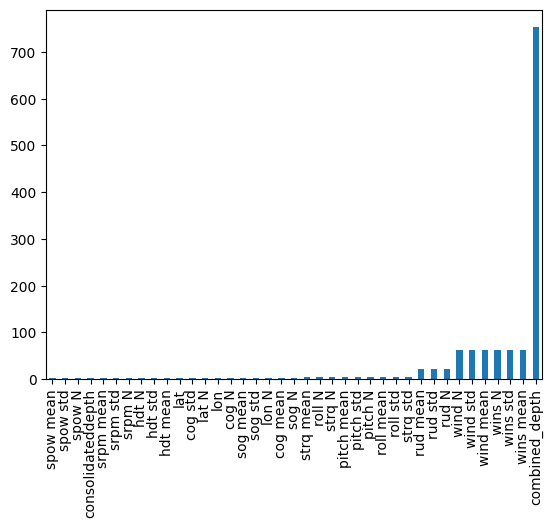

In [57]:
# plot missing values after filtering
missing_values = steady_state_df.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values.sort_values(inplace=True)
missing_values.plot.bar()
plt.show()

Depth readings are too unrealiable because there are so many missing.

In [58]:
# remove columns consolidateddepth and combined_depth
steady_state_df = steady_state_df.drop(columns=['consolidateddepth', 'combined_depth'])

# Display shape after removal
print(steady_state_df.shape)

(29527, 44)


Lets see what still have missing values.

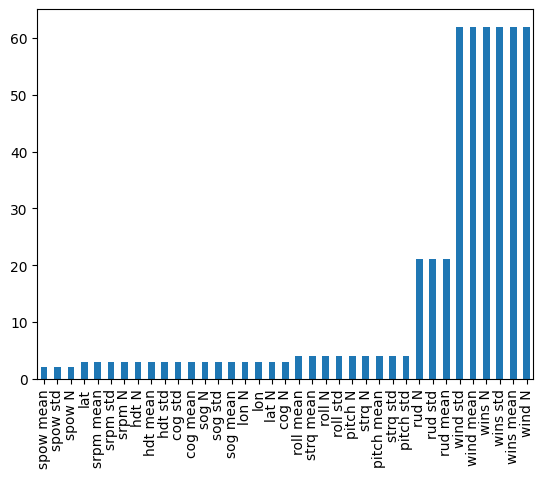

In [59]:
# Graph missing values after removal
missing_values = steady_state_df.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values.sort_values(inplace=True)
missing_values.plot.bar()
plt.show()

Because there are so few missing values left I will remove the rows that have missing values

In [60]:
# remove rows with missing values
steady_state_df = steady_state_df.dropna()

# Display shape after removal
print(steady_state_df.shape)

(29445, 44)


In order to filter for acceleration I will filter out data that has an srpm mean of above 1. As per Søren recormendation.

In [61]:
# print the count of rows with a srpm std greater than 1
print(steady_state_df[steady_state_df['srpm std'] > 1].shape)

# remove rows with srpm std greater than 1
steady_state_df = steady_state_df[steady_state_df['srpm std'] <= 1]

# print the shape after removal
print(steady_state_df.shape)

(23, 44)
(29422, 44)


This should conclude the most obvious steps. Now I will look into outliers of the data that is avaliable. 

Lets start by looking at the histograms too see if there is something that is looking off.

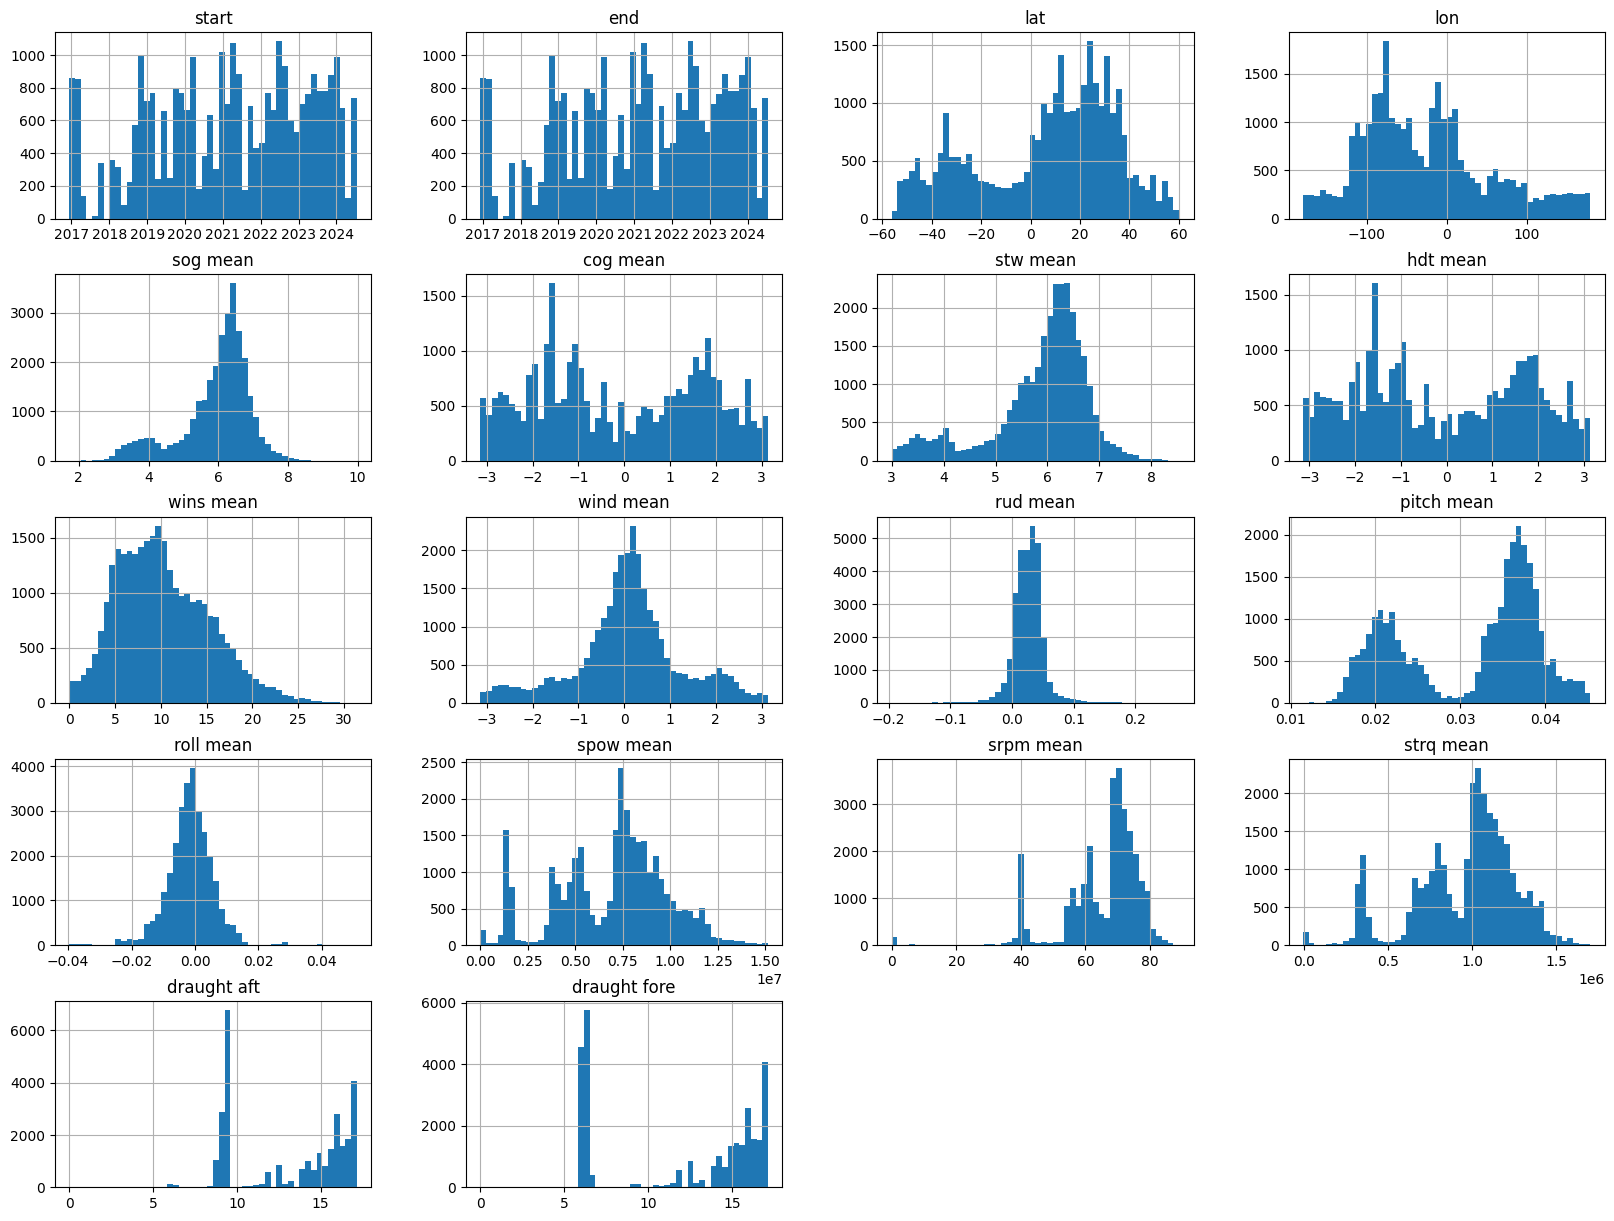

In [62]:
# display histograms of the columns exept the columns that contain std and N
columns = [col for col in steady_state_df.columns if 'std' not in col and 'N' not in col]
steady_state_df[columns].hist(bins=50, figsize=(20, 15))
plt.show()


It looks fine. Lets take a look if there are times where the ship moves but without having power transfered.

In [63]:
# count how many times spow mean is 0
print(steady_state_df[steady_state_df['spow mean'] == 0].shape)

# remove rows where spow mean is 0
steady_state_df = steady_state_df[steady_state_df['spow mean'] != 0]

# display shape after removal
print(steady_state_df.shape)


(172, 44)
(29250, 44)


These values are too low to be realistic.

In [78]:
# remove all points with a spow mean of less than 300000
steady_state_df = steady_state_df[steady_state_df['spow mean'] > 300000]

# display shape after removal
print(steady_state_df.shape)

(29221, 44)


Okay lets see if we can find some more outliers between speed and power.

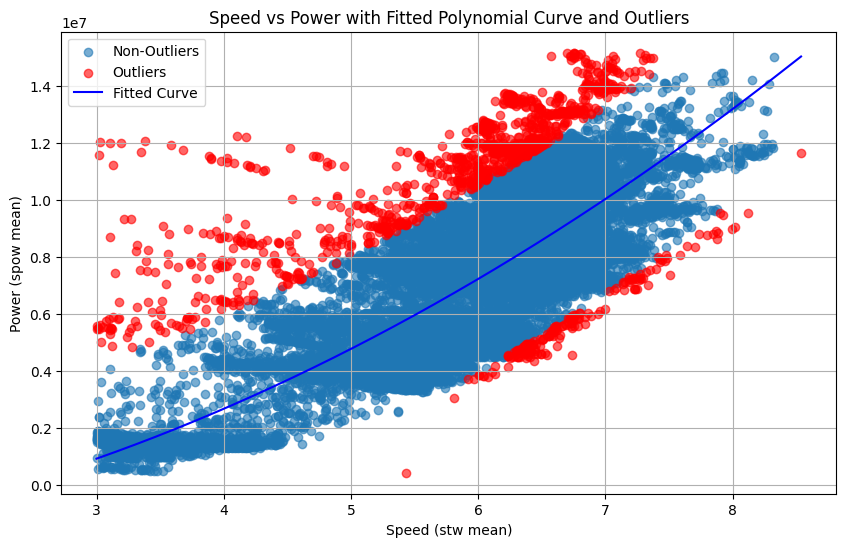

Number of outliers: 1203


In [84]:
# Define a polynomial model for curve fitting and outlier detection
def power_speed_curve(speed, a, b, c, d):
    return a * np.power(speed, 2) + b * np.power(speed, 2) + c * speed + d

# Get the data for curve fitting
speed = steady_state_df['stw mean']
power = steady_state_df['spow mean']

# Fit the curve
popt, _ = curve_fit(power_speed_curve, speed, power)
predicted_power = power_speed_curve(speed, *popt)

# Calculate residuals and identify outliers
residuals = power - predicted_power
threshold = np.std(residuals) * 2
outliers = steady_state_df[np.abs(residuals) > threshold]
non_outliers = steady_state_df[np.abs(residuals) <= threshold]

# Plot the original data, the fitted curve, and highlight outliers
plt.figure(figsize=(10, 6))
plt.scatter(non_outliers['stw mean'], non_outliers['spow mean'], alpha=0.6, label='Non-Outliers')
plt.scatter(outliers['stw mean'], outliers['spow mean'], color='red', alpha=0.6, label='Outliers')
plt.plot(np.sort(speed), power_speed_curve(np.sort(speed), *popt), color='blue', label='Fitted Curve')
plt.title('Speed vs Power with Fitted Polynomial Curve and Outliers')
plt.xlabel('Speed (stw mean)')
plt.ylabel('Power (spow mean)')
plt.legend()
plt.grid(True)
plt.show()

# Display the number of outliers
print('Number of outliers:', outliers.shape[0])

Remove the outliers

In [85]:
# remove the outliers
steady_state_df = non_outliers

# Display shape after removal
print(steady_state_df.shape)

(28018, 44)


Save the dataframe for the next step. Which is feature generation and manipulation.

In [86]:
# save dataframe as a excel file
steady_state_df.to_excel(r'C:\Users\rasmu\Desktop\Speciale\filtered_miss_outlier.xlsx', index=False)